## Feature engineering

In [1]:
# Load pyspark
import findspark

findspark.init()

#import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F, window

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, Bucketizer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import datetime
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données pré-traitées

In [21]:
df_train = spark.read.parquet("data/02-featureEngineering")

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train.printSchema()

df_train = (1456, 29)
root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 |-- station_max_temp_c: float (nullable = true)
 |-- station_min_temp_c: float (nullable = true)
 |-- station_precip_mm: float (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- reanalysis_air_temp_c: double (nullable = true)
 |-- reanalysis_avg_temp_c: double (nullable = true)
 |-- 

In [22]:
# San Juan (sj)
df_train_sj = df_train.filter(df_train.city == 'sj')

# Iquitos (iq)
df_train_iq = df_train.filter(df_train.city == 'iq')

### Décalage

In [23]:
def shift_data(df, shift=0):
    # build a window
    w = window.Window() \
        .partitionBy('city') \
        .orderBy(F.col('week_start_date'))

    # add new columns with different lags
    df = df \
        .withColumn('ndvi_avg',
                    F.lag('ndvi_avg', count=shift).over(w)) \
        .withColumn('reanalysis_precip_amt_kg_per_m2',
                    F.lag('reanalysis_precip_amt_kg_per_m2', count=shift).over(w)) \
        .withColumn('reanalysis_sat_precip_amt_mm',
                    F.lag('reanalysis_sat_precip_amt_mm', count=shift).over(w)) \
        .withColumn('reanalysis_specific_humidity_g_per_kg',
                    F.lag('reanalysis_specific_humidity_g_per_kg', count=shift).over(w)) \
        .withColumn('station_avg_temp_c',
                    F.lag('station_avg_temp_c', count=shift).over(w)) \
        .withColumn('station_diur_temp_rng_c',
                    F.lag('station_diur_temp_rng_c', count=shift).over(w)) \
        .withColumn('station_max_temp_c',
                    F.lag('station_max_temp_c', count=shift).over(w)) \
        .withColumn('station_min_temp_c',
                    F.lag('station_min_temp_c', count=shift).over(w)) \
        .withColumn('station_precip_mm',
                    F.lag('station_precip_mm', count=shift).over(w)) \
        .withColumn('reanalysis_air_temp_c',
                    F.lag('reanalysis_air_temp_c', count=shift).over(w)) \
        .withColumn('reanalysis_avg_temp_c',
                    F.lag('reanalysis_avg_temp_c', count=shift).over(w)) \
        .withColumn('reanalysis_dew_point_temp_c',
                    F.lag('reanalysis_dew_point_temp_c', count=shift).over(w)) \
        .withColumn('reanalysis_max_air_temp_c',
                    F.lag('reanalysis_max_air_temp_c', count=shift).over(w))

    df = df.dropna()
    
    return df

v_shift = 0

print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))

df_train_sj = shift_data(df_train_sj, shift=v_shift)
df_train_iq = shift_data(df_train_iq, shift=v_shift)

print("Applied shift is: {}".format(v_shift))
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))

df_train_sj = (936, 29)
df_train_iq = (520, 29)
Applied shift is: 0
df_train_sj = (936, 29)
df_train_iq = (520, 29)


### Construction des jeux d'entrainement et de test

In [24]:
# split train (90%) and test (10%)

# San Juan (sj)
min_date_sj, max_date_sj = df_train_sj.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

testsize_sj = int(0.1 * df_train_sj.count())
delta_sj = datetime.timedelta(weeks=testsize_sj)
cut_date_sj = max_date_sj - delta_sj

train_sj = df_train_sj.filter(df_train_sj.week_start_date <= cut_date_sj)
test_sj = df_train_sj.filter(df_train_sj.week_start_date > cut_date_sj)

print("train_sj = ({}, {})".format(train_sj.count(), len(train_sj.columns)))
print("test_sj = ({}, {})".format(test_sj.count(), len(test_sj.columns)))

# Iquitos (iq)
min_date_iq, max_date_iq = df_train_iq.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

testsize_iq = int(0.1 * df_train_iq.count())
delta_iq = datetime.timedelta(weeks=testsize_iq)
cut_date_iq = max_date_iq - delta_iq

train_iq = df_train_iq.filter(df_train_iq.week_start_date <= cut_date_iq)
test_iq = df_train_iq.filter(df_train_iq.week_start_date > cut_date_iq)

print("train_iq = ({}, {})".format(train_iq.count(), len(train_iq.columns)))
print("test_iq = ({}, {})".format(test_iq.count(), len(test_iq.columns)))

train_sj = (843, 29)
test_sj = (93, 29)
train_iq = (468, 29)
test_iq = (52, 29)


In [25]:
# concatanate the 2 sets
train = train_sj.union(train_iq)
test = test_sj.union(test_iq)

print("train = ({}, {})".format(train.count(), len(train.columns)))
print("test = ({}, {})".format(test.count(), len(test.columns)))

train = (1311, 29)
test = (145, 29)


### Construction du *pipeline*

In [28]:
# OneHotEncoder categorial variables
indexer = StringIndexer(inputCol='city', outputCol='city_')
encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

# Build feature vector
vectorAssembler = VectorAssembler(
    inputCols=['cityVect',
               'year', 'weekofyear',
##               'bucket_ne', 'bucket_nw', 'bucket_se', 'bucket_sw',
               'ndvi_avg',
               'reanalysis_precip_amt_kg_per_m2',
##               'reanalysis_relative_humidity_percent',
               'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',  
               'reanalysis_air_temp_c',
               'reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c',
               'reanalysis_max_air_temp_c',
##               'reanalysis_min_air_temp_c',
##               'reanalysis_tdtr_c',
               ], 
    outputCol = 'features')

# scaler
scaler = StandardScaler(inputCol='features',
                        outputCol='scaled_features',
                        withStd=True, withMean=True)

# Random forest
rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

### Modèle *Random Forest* (forêt aléatoire)

#### Paramètres par défaut

In [29]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

# build model
model_rf = pipeline_rf.fit(train)

# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

#pred_rf.select(['total_cases','rf_prediction']).show(52)

mae = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - MAE = {:.3f}".format(mae))

Random Forest::Before grid search - MAE = 13.089


#### Ajustement des hyper-paramètres (*grid search*)

In [30]:
#numTrees = [15, 20, 25, 30, 40, 50, 60]
numTrees = [30, 35, 40, 45, 50, 55]
#maxDepths = [2, 4, 5, 7, 10, 15, 20]
maxDepths = [3, 4, 5, 6, 7, 8]

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

rf_bestModel = model_rf
best_mae = mae

for nTree in numTrees:
    for depth in maxDepths:

        print("numTree={}, maxDepth={}".format(nTree, depth))
        rf = RandomForestRegressor(featuresCol='scaled_features',
                                   labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   numTrees=nTree,
                                   maxDepth=depth)

        pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

        # build model
        model = pipeline.fit(train)

        # Build prediction from 'test' dataset
        pred = model.transform(test)

        mae = evaluator_rf.evaluate(pred)
        if mae < best_mae:
            best_mae = mae
            rf_bestModel = model

pred_rf = rf_bestModel.transform(test)

mae = evaluator_rf.evaluate(pred_rf)

numTree = rf_bestModel.stages[-1].getNumTrees
maxDepth = rf_bestModel.stages[-1]._java_obj.getMaxDepth()

print("Best model (numTree={}, MaxDepth={}) => MAE = {:.3f}".format(numTree, maxDepth, mae))

numTree=30, maxDepth=3
numTree=30, maxDepth=4
numTree=30, maxDepth=5
numTree=30, maxDepth=6
numTree=30, maxDepth=7
numTree=30, maxDepth=8
numTree=35, maxDepth=3
numTree=35, maxDepth=4
numTree=35, maxDepth=5
numTree=35, maxDepth=6
numTree=35, maxDepth=7
numTree=35, maxDepth=8
numTree=40, maxDepth=3
numTree=40, maxDepth=4
numTree=40, maxDepth=5
numTree=40, maxDepth=6
numTree=40, maxDepth=7
numTree=40, maxDepth=8
numTree=45, maxDepth=3
numTree=45, maxDepth=4
numTree=45, maxDepth=5
numTree=45, maxDepth=6
numTree=45, maxDepth=7
numTree=45, maxDepth=8
numTree=50, maxDepth=3
numTree=50, maxDepth=4
numTree=50, maxDepth=5
numTree=50, maxDepth=6
numTree=50, maxDepth=7
numTree=50, maxDepth=8
numTree=55, maxDepth=3
numTree=55, maxDepth=4
numTree=55, maxDepth=5
numTree=55, maxDepth=6
numTree=55, maxDepth=7
numTree=55, maxDepth=8
Best model (numTree=50, MaxDepth=3) => MAE = 12.797


#### Résultats

shift=0, Best model (numTree=50, MaxDepth=3) => MAE = 12.797
shift=1,
shift=2, Best model (numTree=55, MaxDepth=3) => MAE = 12.486
shift=3, Best model (numTree=50, MaxDepth=4) => MAE = 12.465
shift=4, Best model (numTree=30, MaxDepth=3) => MAE = 12.544

#### Affichage des predictions obtenues

Nous mesurons la performance du modèle en ragardant les prédictions sur le jeu de données d'entrainement.

In [10]:
pd_train_sj = train_sj.toPandas()
pd_train_iq = train_iq.toPandas()

# create pandas dataframe from spark dataframe
pd_pred_rf = pred_rf.toPandas()

pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

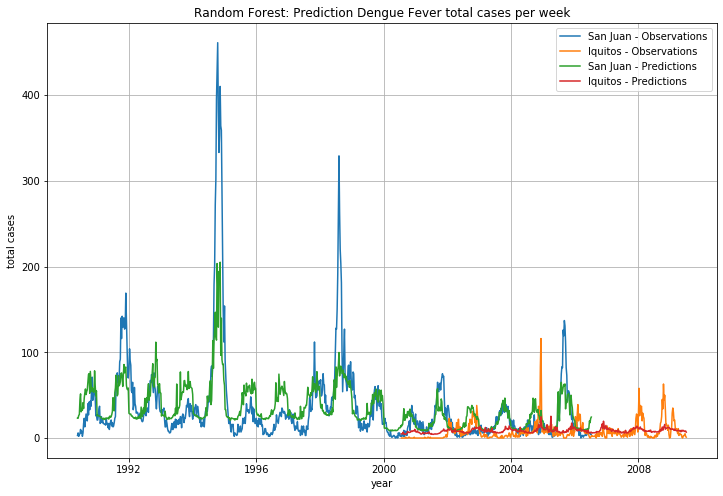

In [11]:
pred_train = rf_bestModel.transform(train)

# create pandas dataframe from spark dataframe
pd_pred_train = pred_train.toPandas()

pd_pred_train_sj = pd_pred_train[pd_pred_train['city'] == 'sj']
pd_pred_train_iq = pd_pred_train[pd_pred_train['city'] == 'iq']

# Total cases per city
fig = plt.figure(figsize=(12, 8))
plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'],
         label='San Juan - Observations')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'],
         label='Iquitos - Observations')

plt.plot(pd_pred_train_sj['week_start_date'], pd_pred_train_sj['rf_prediction'],
         label='San Juan - Predictions')
plt.plot(pd_pred_train_iq['week_start_date'], pd_pred_train_iq['rf_prediction'],
         label='Iquitos - Predictions')

plt.legend()

fig.savefig("figs/05-fig_01.jpg")
plt.show()

## plot LR

### try on test bench

In [ ]:
df_bench = spark.read.parquet("data/preprocessed_bench")

print("df_bench = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

In [ ]:
# simple RF
bench_simple_rf = cv_model_rf.transform(df_bench)

In [ ]:
df_submission = spark.read.csv('data/submission_format.csv',header=True)
df_submission.show(10)

In [ ]:
df_temp = bench_simple_rf['city', 'year', 'weekofyear','rf_prediction']
df_temp = df_temp.withColumn("total_cases", df_temp["rf_prediction"].cast('int'))
df_temp = df_temp.drop('rf_prediction')

In [ ]:
df_temp.show(10)

In [ ]:
df_temp_pandas = df_temp.select('city','year','weekofyear','total_cases').toPandas()
df_temp_pandas_sj = df_temp_pandas[df_temp_pandas['city'] == 'sj']
df_temp_pandas_iq = df_temp_pandas[df_temp_pandas['city'] == 'iq']
df_temp_pandas = pd.concat([df_temp_pandas_sj,df_temp_pandas_iq], axis=0)

In [ ]:
df_temp_pandas.to_csv('data/test_cv_rf.csv',index=False)

features = ['reanalysis_specific_humidity_g_per_kg', 
            'reanalysis_dew_point_temp_k', 
            'station_avg_temp_c', 
            'station_min_temp_c',
            'reanalysis_min_air_temp_k',
            'reanalysis_max_air_temp_k']  